In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy
from glob import glob
import re
import time
from imgaug import augmenters as iaa
import model as build_ResNet
%load_ext autoreload
%autoreload 2

In [3]:
num_classes = 3

In [4]:
SAVE_DIR ='./save_models'
LOAD_DIR ='./load_models'
DATA_DIR ='./data'
LOG_DIR = './log'
train_path = os.path.join(DATA_DIR, 'Train')
valid_path = os.path.join(DATA_DIR, 'Valid')
test_path = os.path.join(DATA_DIR, 'Test')

## Train

In [ ]:
version = 12
subversion = 8
SAVE_DIR_TEST = os.path.join(SAVE_DIR, 'model_'+str(version)+'_'+ str(subversion))
if not os.path.exists(SAVE_DIR_TEST):
  os.makedirs(SAVE_DIR_TEST)
save_txt_path = os.path.join(SAVE_DIR_TEST, 'log.txt')
with open(save_txt_path, 'a') as f:
  print("Train with (model.py to block3/unit_11) ",file=f)
  
for batch_size in [2]:
  for l2_rate in [1e-4]:
    for weights in [[0.3, 2.4, 0.3]]:
        tf.reset_default_graph()
        with tf.Session() as sess:
          lrn_rate = 7e-4
          epochs = 60
          correct_label = tf.placeholder(tf.float32, [None, None, None,3], name = 'correct_label')
          learning_rate = tf.placeholder(tf.float32,name='learning_rate')
          L2 = tf.placeholder(tf.float32,name='L2')
          load_model_path = os.path.join(LOAD_DIR, 'resnet_slim/ckpt')
          tensors = build_ResNet.build_graph(sess, load_model_path, correct_label, learning_rate, num_classes, L2, weights)

          var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)[544:]
          partial_init_op = tf.variables_initializer(var_list, name='init')
          sess.run(partial_init_op)
          with open(save_txt_path, 'a') as f:
            print("\nB: {0}, L2: {1:3g}, W: {2}, lrn_rate: {3}".format(batch_size, l2_rate, weights, lrn_rate),file=f)
          print("\nB: {0}, L2: {1:3g}, W: {2}, lrn_rate: {3}".format(batch_size, l2_rate, weights, lrn_rate))
          build_ResNet.train_nn_valid(sess, epochs, batch_size, lrn_rate, tensors, l2_rate, (train_path,valid_path), SAVE_DIR_TEST)
          save_model_path = os.path.join(SAVE_DIR_TEST, 'ckpt')
          saver = tf.train.Saver()
          saver.save(sess, save_model_path)

## Re-Train

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
  saver = tf.train.import_meta_graph('save_models/model_12_8/ckpt.meta')
  saver.restore(sess, 'save_models/model_12_8/ckpt')
  graph = tf.get_default_graph()
  tensors = build_ResNet.load_train_tensors(graph)
  
  epochs = 20;
  batch_size = 2
  lrn_rate = 7e-5
  l2_rate = 1e-4
  
  subversion = 8
  SAVE_DIR_TEST = os.path.join(SAVE_DIR, 'model_'+str(version)+'_'+ str(subversion))
  if not os.path.exists(SAVE_DIR_TEST):
    os.makedirs(SAVE_DIR_TEST)

  print("Start Re-trianing....")
  build_ResNet.train_nn_valid(sess, epochs, batch_size, lrn_rate, tensors, l2_rate, (train_path,valid_path), SAVE_DIR_TEST)
  save_model_path = os.path.join(SAVE_DIR_TEST, 'ckpt')
  saver = tf.train.Saver()
  saver.save(sess, save_model_path)

## Convert placeholder to constant

In [7]:
SAVE_INF_DIR = os.path.join(SAVE_DIR, 'model_12_8_1')
save_inf_path = os.path.join(SAVE_INF_DIR,'ckpt')
load_weight_path = os.path.join(SAVE_DIR, 'model_12_8/ckpt')

In [8]:
tf.reset_default_graph()
with tf.Session() as sess:
  build_ResNet.build_graph_inference(sess, './load_models/resnet_slim_inference/ckpt', num_classes)
  saver = tf.train.Saver()
  saver.restore(sess, load_weight_path)
  saver.save(sess, save_inf_path)
  tf.train.write_graph(sess.graph.as_graph_def(), SAVE_INF_DIR, "base_graph.pb")

INFO:tensorflow:Restoring parameters from ./save_models/model/ckpt


In [83]:
tf.reset_default_graph()
with tf.Session() as sess:
  saver = tf.train.import_meta_graph(save_inf_path+'.meta')
  saver.restore(sess, save_inf_path)
  graph = tf.get_default_graph()
  input_image = graph.get_tensor_by_name('input_image:0')
  softmax = graph.get_tensor_by_name('softmax:0')
  
  images = []
  labels = []
  outs = []
  valid_gen = build_ResNet.build_gen_val(test_path)
  corrects = 0
  pixels = 0
  total_time = 0
  total_images = 0
  n_ii = [0] * num_classes
  t_i = [0] * num_classes
  n_ji = [0] * num_classes
  z = 0
  c_tp = 0
  c_se = 0
  c_re = 0
  r_tp = 0
  r_se = 0
  r_re = 0
  for image, label in valid_gen(8):
    print ('{0}'.format(z), end='\r')
    z += 1
    images.append(image)
    labels.append(label)
    feed_dict = {input_image: image}
    total_images += image.shape[0]
    t1 = time.time()
    out = sess.run(softmax, feed_dict=feed_dict)
    t2 = time.time()
    total_time += t2-t1
    outs.append(out)
    corrects += np.sum(np.equal(np.argmax(out,axis = 3),np.argmax(label,axis = 3)))
    pixels += label.shape[0]*label.shape[1]*label.shape[2]
    for i in range(num_classes):
      out_class = np.equal(np.argmax(out,axis = 3),i)
      label_class = np.equal(np.argmax(label,axis = 3),i)
      n_ii[i] += np.sum(out_class & label_class)
      t_i[i] += np.sum(out_class)
      n_ji[i] += np.sum(label_class)
    out = np.argmax(out,axis = 3)
    car_mask = np.where(out==1,1,0)
    car_label_mask = label[:,:,:,1]
    c_tp += np.sum(car_mask & car_label_mask)
    c_se += np.sum(car_mask)
    c_re += np.sum(car_label_mask)
    road_mask = np.where(out==2,1,0)
    road_label_mask = label[:,:,:,2]
    r_tp += np.sum(road_mask & road_label_mask)
    r_se += np.sum(road_mask)
    r_re += np.sum(road_label_mask)

  mean_IU = 0
  mean_accuracy = 0
  c_P = c_tp/c_se
  c_R = c_tp/c_re
  r_P = r_tp/r_se
  r_R = r_tp/r_re
  for i in range(num_classes):
    mean_accuracy += n_ii[i]/t_i[i]/num_classes
    mean_IU += n_ii[i]/(t_i[i]+n_ji[i]-n_ii[i])/num_classes
  pixel_accuracy = np.sum(n_ii)/np.sum(t_i)
  
  print("Pixel Accuracy: {0:3g}, Mean Accuracy: {1:3g}, Mean IU: {2:3g}".format(pixel_accuracy,mean_accuracy,mean_IU))
  print("Car Precision: {0:.3g} | Car Recall: {1:.3g} | Road Precision: {2:.3g} | Road Recall: {3:.3g} ".format(c_P,c_R,r_P,r_R))
  print("FPS: {0:3g}".format(total_images/total_time))

INFO:tensorflow:Restoring parameters from ./save_models/model/ckpt
Pixel Accuracy: 0.994026, Mean Accuracy: 0.958664, Mean IU: 0.950347
Car Precision: 0.881 | Car Recall: 0.982 | Road Precision: 0.997 | Road Recall: 0.994 
FPS: 68.6799


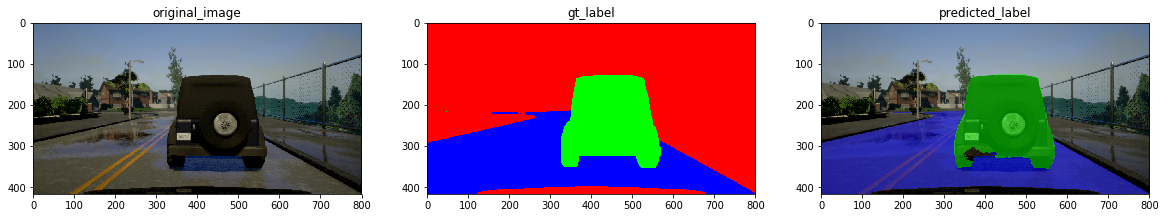

In [202]:
import random
idx = random.randint(0,len(images)-1)
idxx = random.randint(0,images[idx].shape[0]-1)

image = images[idx][idxx]
label = labels[idx][idxx]
out_car = np.equal(np.argmax(outs[idx][idxx],axis =2),1)
mask_car = np.dot(out_car.reshape([416,800,1]), np.array([[0, 255, 0, 127]]))
mask_car = scipy.misc.toimage(mask_car, mode="RGBA")
out_road = np.equal(np.argmax(outs[idx][idxx],axis =2),2)
mask_road = np.dot(out_road.reshape([416,800,1]), np.array([[0, 0, 255, 127]]))
mask_road = scipy.misc.toimage(mask_road, mode="RGBA")
image_merge = scipy.misc.toimage(image)
image_merge.paste(mask_car, box=None, mask=mask_car)
image_merge.paste(mask_road, box=None, mask=mask_road)
plt.subplot(131)
plt.title('original_image')
plt.imshow(image)
plt.subplot(132)
plt.title('gt_label')
plt.imshow(labels[idx][idxx]*255)
plt.subplot(133)
plt.title('predicted_label')
plt.imshow(image_merge)
plt.gcf().set_size_inches(20,20)